In [9]:
import sys
sys.path.append('C:/maldb/python/mlp/')

import tensorflow as tf
from tensorflow import keras

import numpy as np
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from ionizer import *

In [11]:
#METHODS FOR VECTORZING DATA

#When we shuffle our training and test arrays, we need to shuffle them in unison so that the indices in the labels array line up with their corresponding peptide in the training array.
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def aa_to_int(char):
    aa_map = {
    'A': 0,
    'C': 1,
    'D': 2,
    'E': 3,
    'F': 4,
    'G': 5,
    'H': 6,
    'I': 7,
    'K': 8,
    'L': 9,
    'M': 10,
    'N': 11,
    'P': 12,
    'Q': 13,
    'R': 14,
    'S': 15,
    'T': 16,
    'V': 17,
    'W': 18,
    'Y': 19
}
    
    return(aa_map[char])

def pad_peptide(arr, max_dim=64):
    return np.pad(arr, [(0, max_dim - arr.shape[0]), (0, 0)])

def one_hot_padded_sequence(seq):
    chars = []
    chars[:] = seq
    aaints = np.vectorize(aa_to_int)(chars)
    one_hot = keras.utils.to_categorical(aaints, num_classes=20)
    return pad_peptide(one_hot)
    
def vectorize_sequences(seqs):
    vectorized = []
    for seq in seqs:
        vectorized.append(one_hot_padded_sequence(seq))
    return np.array(vectorized)

In [12]:
#Get the data from the excel sheet, calculate feature vectors for each entry (row) using ionizers.py
train_vecs, train_seqs, train_labels = get_ionizer_training_data('C:/maldb/python/mlp/data/ionizers.csv')

#Let's vectorize our sequences
x_train = vectorize_sequences(train_seqs)
y_train = train_labels.astype('float32')

#Shuffle!
x_train, y_train = unison_shuffled_copies(x_train, y_train)

#Make a test set
test_set_size = 50
x_test = x_train[:test_set_size]
y_test = y_train[:test_set_size]

x_train = x_train[test_set_size:]
y_train = y_train[test_set_size:]

In [18]:
#Lets build a 1D convolutional model
from keras import models
from keras import layers

def build_model():

    model = models.Sequential()
    model.add(layers.Conv1D(1, kernel_size=12, activation="relu", input_shape=(64,20)))
    model.add(layers.MaxPooling1D(8))
    model.add(layers.Conv1D(1, kernel_size=6, activation="relu"))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[
            keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
            tf.keras.metrics.Precision(), 
            tf.keras.metrics.Recall()
        ],
    )
    
    #model.summary()
    
    return model

In [27]:
#Define the number of folds... this will give us an 80/20 split
k = 5
epochs = 1000
num_val_samples = len(x_train) // k
scores_binacc = []
scores_precision = []
scores_recall = []
histories = []

#Train the dense model in k iterations
for i in range(k):
    print('Processing fold #', i)
    val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    
    print('Validation partition =  ', i * num_val_samples, (i + 1) * num_val_samples)
    print('Training partition 1 = ', 0, i * num_val_samples)
    print('Training partition 2 = ', (i+1) * num_val_samples, len(x_train))
    
    partial_train_data = np.concatenate(
        [
            x_train[:i * num_val_samples],
            x_train[(i+1) * num_val_samples:]
        ], 
        axis=0
    )
    
    partial_train_targets = np.concatenate(
        [
            y_train[:i * num_val_samples],
            y_train[(i+1) * num_val_samples:]
        ],
        axis=0
    )
    
    model = build_model()
    h = model.fit(
        partial_train_data, 
        partial_train_targets, 
        validation_data=(val_data, val_targets),
        epochs=epochs, 
        verbose=0
    )
    
    val_loss, val_binacc, val_precision, val_recall = model.evaluate(val_data, val_targets, verbose=0)
    scores_binacc.append(val_binacc)
    scores_precision.append(val_precision)
    scores_recall.append(val_recall)
    histories.append(h)

Processing fold # 0
Validation partition =   0 123
Training partition 1 =  0 0
Training partition 2 =  123 616
Processing fold # 1
Validation partition =   123 246
Training partition 1 =  0 123
Training partition 2 =  246 616
Processing fold # 2
Validation partition =   246 369
Training partition 1 =  0 246
Training partition 2 =  369 616
Processing fold # 3
Validation partition =   369 492
Training partition 1 =  0 369
Training partition 2 =  492 616
Processing fold # 4
Validation partition =   492 615
Training partition 1 =  0 492
Training partition 2 =  615 616


In [26]:
print('Mean Validation Binary Accuracy: ', np.mean(scores_binacc))
print('Mean Validation Precision: ', np.mean(scores_precision))
print('Mean Validation Recall: ', np.mean(scores_recall))

x_test_predictions = model.predict(np.array(x_test))

b = keras.metrics.BinaryAccuracy()
p = keras.metrics.Precision() 
r = keras.metrics.Recall()

print(y_test)

b.update_state(
    [y_test],
    [x_test_predictions]
)
p.update_state(
    [y_test],
    [x_test_predictions]
)
r.update_state(
    [y_test],
    [x_test_predictions]
)

print('Test Binary Accuracy: ', b.result().numpy())
print('Test Precision: ', p.result().numpy())
print('Test Recall: ', r.result().numpy())

Mean Validation Binary Accuracy:  0.8276718735694886
Mean Validation Precision:  0.6661903738975525
Mean Validation Recall:  0.6321940183639526
[1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1.]
Test Binary Accuracy:  0.72
Test Precision:  0.5833333
Test Recall:  0.4375


<ipython-input-41-d3212d62f09d>:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-41-d3212d62f09d>:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)


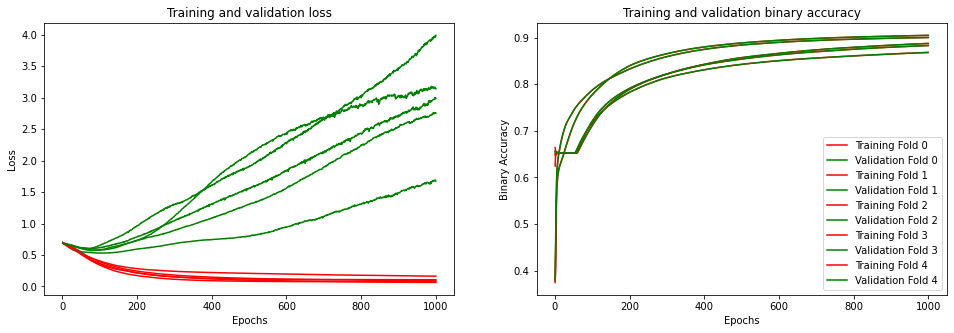

In [41]:
#PLOTS
plt.figure(figsize=(25, 5))



e = range(1, epochs + 1)
    
for i, h in enumerate(histories):
    plt.subplot(131)
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(e, histories[i].history['loss'], 'r-', label='Training Fold ' + str(i))
    plt.plot(e, histories[i].history['val_loss'], 'g-', label='Validation Fold ' + str(i))
    
    plt.subplot(132)
    plt.title('Training and validation binary accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Binary Accuracy')
    plt.plot(e, histories[i].history['binary_accuracy'], 'r-', label='Training Fold ' + str(i))
    plt.plot(e, histories[i].history['val_binary_accuracy'], 'g-', label='Validation Fold ' + str(i))
    
    

plt.legend()
plt.show()

(array([306.,  39.,  15.,  11.,   9.,   6.,  10.,   1.,   5.,   0.,   1.,
          5.,   4.,   1.,   3.,   3.,   1.,   1.,   3.,   3.,   0.,   2.,
          0.,   3.,   3.,   3.,   3.,   0.,   1.,   4.,   1.,   3.,   1.,
          0.,   1.,   1.,   6.,   1.,   3.,   1.,   1.,  18.,   1.,   3.,
          2.,   1.,   3.,   3.,   6., 164.]),
 array([1.33218937e-29, 1.93502493e-02, 3.87004986e-02, 5.80507480e-02,
        7.74009973e-02, 9.67512503e-02, 1.16101496e-01, 1.35451749e-01,
        1.54801995e-01, 1.74152255e-01, 1.93502501e-01, 2.12852746e-01,
        2.32202992e-01, 2.51553237e-01, 2.70903498e-01, 2.90253758e-01,
        3.09603989e-01, 3.28954250e-01, 3.48304510e-01, 3.67654741e-01,
        3.87005001e-01, 4.06355232e-01, 4.25705492e-01, 4.45055753e-01,
        4.64405984e-01, 4.83756244e-01, 5.03106475e-01, 5.22456765e-01,
        5.41806996e-01, 5.61157227e-01, 5.80507517e-01, 5.99857748e-01,
        6.19207978e-01, 6.38558269e-01, 6.57908499e-01, 6.77258730e-01,
        6.

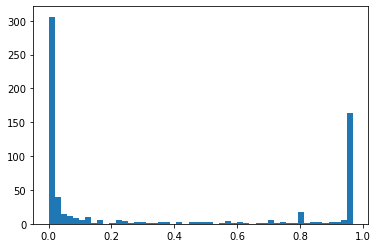

In [7]:
plt.hist(cmodel.predict(x_train_seqs), bins=50)